In [1]:
# Owner: Lia Furtado

In [1]:
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk 
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import unicodedata
from collections import Counter
import spacy
import string
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import math
from gensim.models import word2vec
import time
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding
from plotly.subplots import make_subplots
import plotly.express as px
from gensim.models.ldamodel import LdaModel
from nltk.collocations import *
from gensim.corpora.dictionary import Dictionary
import umap

import ipywidgets as widgets


import seaborn as sns
from itertools import combinations
from sentence_transformers import SentenceTransformer
import nxviz as nv
from nxviz import annotate
import networkx as nx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\lfurtado\Anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Objectif: 
## Demarche: 
## Introduction/Plan

In [2]:
data = pd.read_csv('dblp_2016_cleaned.csv')  

In [3]:
data['text_clean_tokenized'] = data['text_clean'].apply(lambda x:nltk.word_tokenize(x))


In [4]:
#delete when there is no venue
data = data[~data['venue'].isnull()] 


In [5]:
def cleanup_authors(msg):
    #removing []
    sentence = re.sub(r"[\([{})\]]",r'', msg)
    #removing '' and .
    sentence = sentence.replace("'", "").replace(".", "") 
    sentence = sentence.replace("\\", "").replace("/", "") 
    sentence = sentence.replace('"','') 
    #remove all non latin caracters
    sentence = re.sub(r'[^\x00-\x7f]',r'', sentence)
    #removing digits
    sentence = re.sub("\S*\d+\S*", "", sentence)
    #remove diactric accents and greek letters
    sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence)
                  if unicodedata.category(c) != 'Mn')
    #hyphen the authors
    sentence = list(sentence.split(", "))
    sentence = [word.lower().replace(' ','-') for word in sentence]
    return sentence

In [6]:
def cleanup_venue(msg):
    #removing pontuation
    No_Punctuation = [char if char not in string.punctuation else ' ' for char in msg ]
    sentence = ''.join(No_Punctuation)
    #removing []
    sentence = re.sub(r"[\([{})\]]",r'', msg)
    #removing '' and .
    sentence = sentence.replace(":", "") 
    sentence = sentence.replace(".", "")
    sentence = sentence.replace("\\", "").replace("/", "") 
    sentence = sentence.replace('"','') 
    sentence = sentence.replace("& ", "")
    sentence = sentence.replace("and ", "")
    #hyphen the authors
    sentence = list(sentence.split(", "))
    sentence = [word.lower().replace(' ','-') for word in sentence]
    return sentence

In [7]:
data['authors_clean'] = data['authors'].apply(lambda x:cleanup_authors(x))
data['venue_clean'] = data['venue'].apply(lambda x:cleanup_venue(x))

In [8]:
bag_of_authors = [item for sublist in data['authors_clean'] for item in sublist]

bag_of_venues = [item for sublist in data['venue_clean'] for item in sublist]

Text(0.5, 1.0, 'Top 10 Venues')

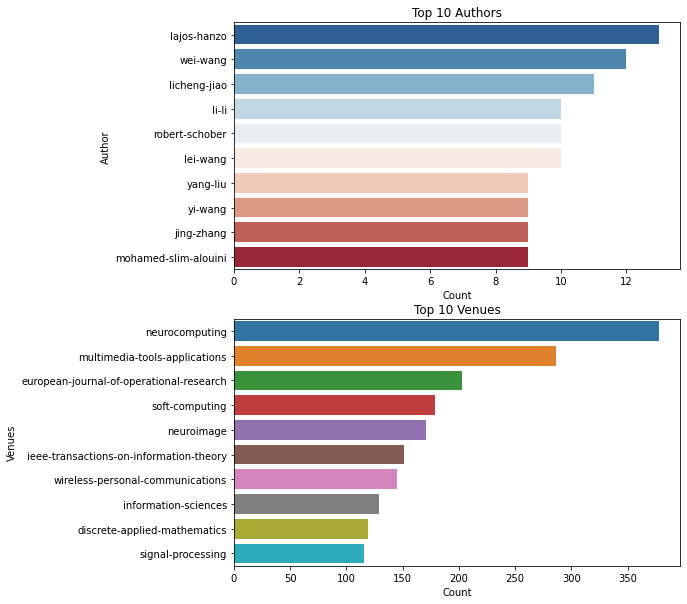

In [9]:
# Top 10 authors
plt.figure(figsize=(8, 10)) 

plt.subplot(2, 1, 1)

top10authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(10), columns=["Author", "Count"]
)
sns.barplot(x="Count", y="Author", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")

plt.subplot(2, 1, 2)

# TOP 10 Venues
top10venues = pd.DataFrame.from_records(
    Counter(bag_of_venues).most_common(10),
    columns=["Venues", "Count"],
)

sns.barplot(x="Count", y="Venues", data=top10venues)
plt.title("Top 10 Venues")

In [10]:
#Each author now becomes a node and the connection between two is an edge.

In [11]:
data[data['venue_clean'].apply(lambda x: len(set(x))>1)]


,abstract,authors,n_citation,references,title,venue,year,id,text,text_clean,text_clean_tokenized,authors_clean,venue_clean
11,"With the recent development of technology, wir...","['Biljana L. Stojkoska', 'Ilinka Ivanoska', 'D...",50,"['103e12c7-7e82-4a02-a695-155e93f74e14', 'a695...",Wireless Sensor Networks Localization Methods:...,"arXiv: Distributed, Parallel, and Cluster Comp...",2016,91c9a7ae-4cf8-4e7b-a01a-647db5ba4dec,Wireless Sensor Networks Localization Methods:...,wireless sensor localization multidimensional ...,"[wireless, sensor, localization, multidimensio...","[biljana-l-stojkoska, ilinka-ivanoska, danco-d...","[arxiv-distributed, parallel, cluster-computing]"
51,Motif finding is one of the NP-complete proble...,"['Jhoirene B. Clemente', 'Francis George C. Ca...",50,"['36653de4-ccd6-49d2-8f6d-25c1b7f4f856', '4e71...",PROJECTION Algorithm for Motif Finding on GPUs,"arXiv: Distributed, Parallel, and Cluster Comp...",2016,c49bdd5a-4ead-456c-924e-abbb1546c65a,PROJECTION Algorithm for Motif Finding on GPUs...,projection motif finding gpus motif finding np...,"[projection, motif, finding, gpus, motif, find...","[jhoirene-b-clemente, francis-george-c-cabarle...","[arxiv-distributed, parallel, cluster-computing]"
66,Electrodynamic bearings exploit repulsive forc...,"['Nicola Amati', 'Fabrizio Impinna', 'J.G. Det...",0,NaN,Test and theory of electrodynamic bearings cou...,Proceedings of the Institution of Mechanical E...,2016,f52dcb18-54f8-45c2-8d62-b096a2bb0b9c,Test and theory of electrodynamic bearings cou...,test theory electrodynamic bearings coupled ac...,"[test, theory, electrodynamic, bearings, coupl...","[nicola-amati, fabrizio-impinna, jg-detoni, an...",[proceedings-of-the-institution-of-mechanical-...
67,"In this paper, we propose a collective decisio...","['Alexander Scheidler', 'Arne Brutschy', 'Elis...",7,"['0203ea7e-643e-442f-bef1-b2ee7b1da5e3', '074a...",The ${k}$ -Unanimity Rule for Self-Organized D...,"IEEE Transactions on Systems, Man, and Cyberne...",2016,35858dee-d441-4d3a-be7e-a2abe5d2ca87,The ${k}$ -Unanimity Rule for Self-Organized D...,unanimity rule self organized decision making ...,"[unanimity, rule, self, organized, decision, m...","[alexander-scheidler, arne-brutschy, eliseo-fe...","[ieee-transactions-on-systems, man, cybernetics]"
200,The goal of regression testing is to ensure th...,"['Rawad Abou Assi', 'Fadi A. Zaraket', 'Wes Ma...",50,"['022d57a1-668e-4823-bf3e-e1a761a075de', '0302...",UCov: a User-Defined Coverage Criterion for Te...,"Software Testing, Verification & Reliability",2016,9fd02565-1585-4fb6-bb25-704caa4798a7,UCov: a User-Defined Coverage Criterion for Te...,ucov user defined coverage criterion test case...,"[ucov, user, defined, coverage, criterion, tes...","[rawad-abou-assi, fadi-a-zaraket, wes-masri]","[software-testing, verification-reliability]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10839,The homogeneous weight on a finite Frobenius r...,['Heide Gluesing-Luerssen'],50,"['0138c35e-2003-44e8-8286-37897684db04', '27dc...",The homogeneous weight partition and its chara...,"Designs, Codes and Cryptography",2016,32e777af-bd22-46c7-bed4-64fe216a48f7,The homogeneous weight partition and its chara...,homogeneous weight partition character theoret...,"[homogeneous, weight, partition, character, th...",[heide-gluesing-luerssen],"[designs, codes-cryptography]"
10889,An optimal control method is developed for unk...,"['Ruizhuo Song', 'Frank L. Lewis', 'Qinglai We...",50,"['08298542-c6c8-4956-902a-b3c68716950a', '0fa4...",Off-Policy Actor-Critic Structure for Optimal ...,"IEEE Transactions on Systems, Man, and Cyberne...",2016,358ee0b3-9f08-429d-8629-f14bda918252,Off-Policy Actor-Critic Structure for Optimal ...,policy actor critic structure optimal unknown ...,"[policy, actor, critic, structure, optimal, un...","[ruizhuo-song, frank-l-lewis, qinglai-wei, hua...","[ieee-transactions-on-systems, man, cybernetics]"
10959,This paper introduces a new system-level fault..

In [12]:
data[data['authors_clean'].apply(lambda x: '-keskin' in x) ]


,abstract,authors,n_citation,references,title,venue,year,id,text,text_clean,text_clean_tokenized,authors_clean,venue_clean
8905,With high-order methods becoming increasingly ...,"['David Moxey', 'D. Ekelschot', 'Ü. Keskin', '...",12,"['10be84e2-41ff-444e-84f5-cdb26b8919c8', '29f5...",High-order curvilinear meshing using a thermo-...,Computer-aided Design,2016,64e57559-cc34-43b0-99d7-2da15c1d051f,High-order curvilinear meshing using a thermo-...,curvilinear meshing thermo elastic analogy bec...,"[curvilinear, meshing, thermo, elastic, analog...","[david-moxey, d-ekelschot, -keskin, spencer-j-...",[computer-aided-design]


In [134]:
top20authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(20), columns=["Name", "Count"])

articles_20_common_authors = []
for index, connection in df_connections.iterrows():
    for author in list(top20authors['Name']):
        if (author in connection['authors_clean']):
            articles_20_common_authors.append(connection)
            
df_20 = pd.DataFrame(articles_20_common_authors)

In [139]:
df_20

,title,text_clean,text_clean_tokenized,authors_clean,venue_clean,authors_combination,From,To
0,Advanced interference management technique: po...,advanced interference management technique pot...,"[advanced, interference, management, technique...","[namyoon-lee, robert-w-heath]",[ieee-wireless-communications],"(robert-w-heath, namyoon-lee)",robert-w-heath,namyoon-lee
1,Energy Dissipation Versus Delay Tradeoffs in a...,energy dissipation versus delay tradeoffs buff...,"[energy, dissipation, versus, delay, tradeoffs...","[chen-dong, li-li, bo-zhang, lie-liang-yang, l...",[ieee-transactions-on-vehicular-technology],"(lajos-hanzo, lie-liang-yang)",lajos-hanzo,lie-liang-yang
2,Energy Dissipation Versus Delay Tradeoffs in a...,energy dissipation versus delay tradeoffs buff...,"[energy, dissipation, versus, delay, tradeoffs...","[chen-dong, li-li, bo-zhang, lie-liang-yang, l...",[ieee-transactions-on-vehicular-technology],"(lajos-hanzo, bo-zhang)",lajos-hanzo,bo-zhang
3,Energy Dissipation Versus Delay Tradeoffs in a...,energy dissipation versus delay tradeoffs buff...,"[energy, dissipation, versus, delay, tradeoffs...","[chen-dong, li-li, bo-zhang, lie-liang-yang, l...",[ieee-transactions-on-vehicular-technology],"(lajos-hanzo, li-li)",lajos-hanzo,li-li
4,Energy Dissipation Versus Delay Tradeoffs in a...,energy dissipation versus delay tradeoffs buff...,"[energy, dissipation, versus, delay, tradeoffs...","[chen-dong, li-li, bo-zhang, lie-liang-yang, l...",[ieee-transactions-on-vehicular-technology],"(lajos-hanzo, chen-dong)",lajos-hanzo,chen-dong
...,...,...,...,...,...,...,...,...
1434,Subspace-based continuous-time identification ...,subspace continuous identification fractional ...,"[subspace, continuous, identification, fractio...","[yangsheng-hu, yuan-fan, yiheng-wei, yong-wang...",[international-journal-of-systems-science],"(yong-wang, yuan-fan)",yong-wang,yuan-fan
1435,Subspace-based continuous-time identification ...,subspace continuous identification fractional ...,"[subspace, continuous, identification, fractio...","[yangsheng-hu, yuan-fan, yiheng-wei, yong-wang...",[international-journal-of-systems-science],"(yong-wang, yangsheng-hu)",yong-wang,yangsheng-hu
1436,Subspace-based continuous-time identification ...,subspace continuous identification fractional ...,"[subspace, continuous, identification, fractio...","[yangsheng-hu, yuan-fan, yiheng-wei, yong-wang...",[international-journal-of-systems-science],"(yiheng-wei, yuan-fan)",yiheng-wei,yuan-fan
1437,Subspace-based continuous-time identification ...,subspace continuous identification fractional ...,"[subspace, continuous, identification, fractio...","[yangsheng-hu, yuan-fan, yiheng-wei, yong-wang...",[international-journal-of-systems-science],"(yiheng-wei, yangsheng-hu)",yiheng-wei,yangsheng-hu


In [135]:
df_20['authors_combination'] = df_20['authors_clean'].apply(lambda x: list(combinations(x[::-1], 2)))
df_20 = df_20.explode('authors_combination','venue_clean')

df_20 = df_20[~df_20['authors_combination'].isnull()] 
df_20.reset_index(inplace=True, drop=True)
df_20['From'], df_20['To'] = zip(*df_20.authors_combination)

In [136]:
df_graph = df_20[['From', 'To', 'title']]

In [140]:
df_graph

,From,To,title
0,robert-w-heath,namyoon-lee,Advanced interference management technique: po...
1,lajos-hanzo,lie-liang-yang,Energy Dissipation Versus Delay Tradeoffs in a...
2,lajos-hanzo,bo-zhang,Energy Dissipation Versus Delay Tradeoffs in a...
3,lajos-hanzo,li-li,Energy Dissipation Versus Delay Tradeoffs in a...
4,lajos-hanzo,chen-dong,Energy Dissipation Versus Delay Tradeoffs in a...
...,...,...,...
1434,yong-wang,yuan-fan,Subspace-based continuous-time identification ...
1435,yong-wang,yangsheng-hu,Subspace-based continuous-time identification ...
1436,yiheng-wei,yuan-fan,Subspace-based continuous-time identification ...
1437,yiheng-wei,yangsheng-hu,Subspace-based continuous-time identification ...


In [137]:
MG= nx.from_pandas_edgelist(df_graph, 'From', 'To', edge_attr=['title'], 
                                 create_using=nx.MultiGraph())

MG.edges(data=True)

MultiEdgeDataView([('robert-w-heath', 'namyoon-lee', {'title': 'Advanced interference management technique: potentials and limitations'}), ('robert-w-heath', 'namyoon-lee', {'title': 'Cooperative Base Station Coloring for Pair-Wise Multi-Cell Coordination'}), ('robert-w-heath', 'namyoon-lee', {'title': 'Spectral Efficiency Scaling Laws in Dense Random Wireless Networks With Multiple Receive Antennas'}), ('robert-w-heath', 'tianyang-bai', {'title': 'Performance Analysis of Outdoor mmWave Ad Hoc Networks'}), ('robert-w-heath', 'tianyang-bai', {'title': 'Analyzing Uplink SINR and Rate in Massive MIMO Systems Using Stochastic Geometry'}), ('robert-w-heath', 'andrew-thornburg', {'title': 'Performance Analysis of Outdoor mmWave Ad Hoc Networks'}), ('robert-w-heath', 'matthew-c-valenti', {'title': 'Device-to-Device Millimeter Wave Communications: Interference, Coverage, Rate, and Finite Topologies'}), ('robert-w-heath', 'kiran-venugopal', {'title': 'Device-to-Device Millimeter Wave Communicat

In [138]:
from pyvis.network import Network
net = Network(height='650px', width='100%', font_color='black', notebook =True)
net.from_nx(MG)
net.show("example.html")

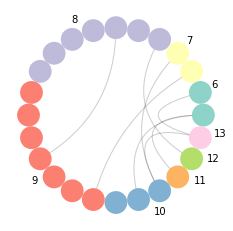

In [133]:
# Limit to TOP 50 authors
G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="title"
)

top50authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )

ax = nv.circos(G_50, group_by="publications", node_color_by="publications")
annotate.circos_group(G_50, group_by="publications")


## Search by Title and find most similiar documents

In [71]:
df_connections = data[['title', 'text_clean', 'text_clean_tokenized','authors_clean', 'venue_clean']]

In [72]:
df_connections.head()

,title,text_clean,text_clean_tokenized,authors_clean,venue_clean
0,Width of Points in the Streaming Model,width points streaming article compute width d...,"[width, points, streaming, article, compute, w...","[alexandr-andoni, huy-l-nguyn]",[symposium-on-discrete-algorithms]
1,Multi-view Metric Learning for Multi-view Vide...,multi view metric multi view video summarizati...,"[multi, view, metric, multi, view, video, summ...","[linbo-wang, xianyong-fang, yanwen-guo, yanwei...",[cyberworlds]
2,A New Method for Classification of Datasets fo...,classification datasets mining decision tree i...,"[classification, datasets, mining, decision, t...","[singh-vijendra, hem-jyotsana-parashar, nisha-...",[arxiv-learning]
3,Full-reference image quality assessment by com...,full reference quality assessment combining gl...,"[full, reference, quality, assessment, combini...","[ashirbani-saha, q-m-jonathan-wu]",[signal-processing]
4,On the commutative quotient of Fomin-Kirillov ...,commutative quotient fomin kirillov algebras f...,"[commutative, quotient, fomin, kirillov, algeb...",[ricky-ini-liu],[european-journal-of-combinatorics]


In [222]:
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [223]:
def text_document_similarity(title, n):
    text = df_connections["text_clean"][df_connections["title"] == title].iloc[0]
    df = df_connections[df_connections["title"] != title]
    df.reset_index(inplace=True)
    
    tagged_docs = []

    for i, list_tokens in enumerate(df['text_clean_tokenized']):
        tagged_docs.append(TaggedDocument(words=list_tokens, tags=[str(i+1)]))

    print('Training Doc2Vec...')

    d2v_model = Doc2Vec(vector_size=100, window=10, min_count=5, workers=11,alpha=0.025)
    d2v_model.build_vocab(tagged_docs)
    d2v_model.train(tagged_docs,total_examples=d2v_model.corpus_count, epochs=20)
    
    
    
    #getting the query and cleaning words that are not in the vocabulary
    query = word_tokenize(text)
    #turning the query into a vector with the same shape as the vectorizer 
    query_vec = d2v_model.infer_vector(query)
    
    print('Comparing text documents...')

    list_similar_values = []
    #Comparing the query with every document in the dataset
    for index, row in df.iterrows():
        document_vec = d2v_model.infer_vector(df['text_clean_tokenized'].iloc[index])
        list_similar_values.append(get_cosine_similarity(document_vec, query_vec))

    #get the top 5 similar documents
    top_ids = np.argsort(list_similar_values)[-n:]
    most_similars_doc = []
    for ids in top_ids:
        most_similars_doc.append({"title" : df['title'].iloc[ids], "cossine_similarity": list_similar_values[ids]})
    return most_similars_doc

In [224]:
def authors_or_venues_in_common(title, most_similars_doc):
    authors = df_connections["authors_clean"][df_connections["title"] == title].iloc[0]
    venues = df_connections["venue_clean"][df_connections["title"] == title].iloc[0]
    #taking out the query author
    updated_docs = []
    
    print('Checking common authors and venues...')

    for doc in most_similars_doc:
        article = df_connections[df_connections["title"] == doc['title']]
            
        for author in authors:
            if (author in article['authors_clean']):
                doc['author'] = author
            else:
                doc['author'] = 'No authors in common'

        for venue in venues:
            if (venue in article['venue_clean']):
                doc['venue'] = venue
            else:
                doc['venue'] = 'No venues in common'
        
        updated_docs.append(doc)
        
    return updated_docs

In [231]:
def find_similiar_documents(title, number_of_documents):
    
    most_similars_doc = text_document_similarity(title, number_of_documents)
    updated_docs = authors_or_venues_in_common(title, most_similars_doc)
    
    results =  pd.DataFrame(updated_docs[::-1])
    print("\n")
    print("Similar documents of: "+ str(title) + "\n")
    print(results)

    return results

In [232]:
dropdown = widgets.Dropdown(options = df_connections.title)

def dropdown_eventhandler(change):
    title = change.new
    results = find_similiar_documents(title, 10)


In [233]:
dropdown.observe(dropdown_eventhandler, names='value')

print("Choose from the listbox the Title you want to find similar documents: ")
display(dropdown)

Choose from the listbox the Title you want to find similar documents: 


Dropdown(options=('Width of Points in the Streaming Model', 'Multi-view Metric Learning for Multi-view Video S…

Training Doc2Vec...
Comparing text documents...
Checking common authors and venues...


Similar documents of: The Rainbow Connection Number of the Power Graph of a Finite Group

                                               title  cossine_similarity  \
0             Compatibility of fuzzy power relations            0.479005   
1  On the power of randomization in network inter...            0.445044   
2             The cost of getting local monotonicity            0.404433   
3  Spatial power indices with applications on rea...            0.397078   
4  The power conjugacy problem in Higman-Thompson...            0.382759   
5  Power usage of production supercomputers and p...            0.374406   
6  Thompson’s group $F$ is 1-counter graph automatic            0.370330   
7  Generalized Fibonacci and Lucas cubes arising ...            0.368048   
8                  Observing CoAP groups efficiently            0.367709   
9  Energy landscapes for the self-assembly of sup...          

In [282]:
def authors_or_venues_in_common(title):
    authors = df_connections["authors_clean"][df_connections["title"] == title][0]
    venues = df_connections["venue_clean"][df_connections["title"] == title][0]
    #taking out the query author
    df = df_connections[df_connections["title"] != title]

    list_common_authors = []
    list_common_venues = []
    for index, article in df.iterrows():
        
        print('Checking common authors...')
            
        for author in authors:
            if (author in article['authors_clean']):
                list_common_authors.append({"title" : article['title'], "author": author})
                
        print('Checking common venues...')

        for venue in venues:
            if (venue in article['venue_clean']):
                list_common_venues.append({"title" : article['title'], "author": venue})
                
    return list_common_authors, list_common_venues

In [311]:
#model for semantic search (query similarity)
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
embeddings = model.encode(data['text_clean'].values)
print(embeddings)

[[ 0.02990917  0.02470112  0.00049384 ...  0.14277485 -0.04096054
  -0.00470103]
 [ 0.03741887 -0.08630216 -0.02435325 ... -0.02804396 -0.05163825
   0.01938225]
 [-0.02655261  0.0862579   0.04219936 ...  0.01161415 -0.01834993
   0.01689634]
 ...
 [-0.01083803 -0.0375764  -0.07169445 ... -0.08485531  0.00271295
   0.05114171]
 [-0.00584158  0.04895869  0.01795788 ... -0.02700021  0.06420294
   0.03360017]
 [ 0.05884707  0.0363559  -0.00641246 ... -0.0240707   0.00848056
  -0.00777332]]


In [312]:
embeddings.shape

(11130, 384)